### PyTorch Datasets ###

In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import logging
import albumentations as alb
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# From the HuggingFace library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor
from transformers import TrainingArguments, Trainer

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData, is_image, yolo2xywh, xywh2yolo
from computervision.transformations import DETRansform

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 12040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/pytorch/pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

xrays_dir = os.path.join(data_dir, 'dentex', 'cropped')

# Load the annotations with data splits
parquet_file_name = 'train_quadrant_enumeration_dset.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')

data_dir: /app/data


In [3]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

In [4]:
# Let's validate the image data before we do anything else
for file_name in df['file_name'].unique():
    bad_files = []
    if not is_image(os.path.join(xrays_dir, file_name)):
        bad_files.append(file_name)
if len(bad_files) == 0:
    print('All files are good!')
else:
    print(f'Could not open these files: \n {bad_files}')

All files are good!


In [5]:
display(df.head())

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8,train
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7,train
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6,train
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5,train
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4,train


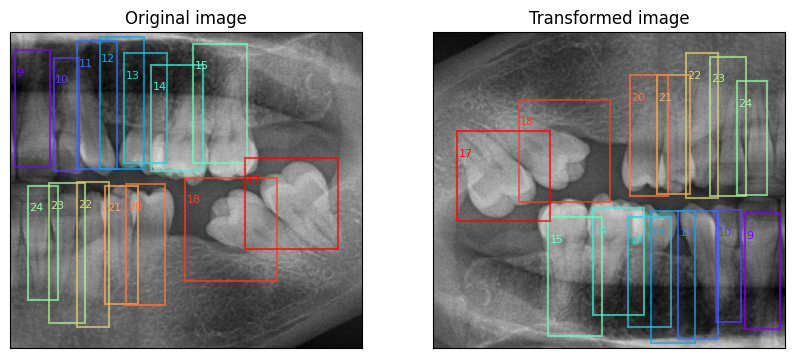

In [6]:
idx = 350
file_list = sorted(list(df['file_name'].unique()))
file = os.path.join(xrays_dir, file_list[idx])
im = ImageData().load_image(file)
# We need an RGB image as input for the model
im = ImageData().np2color(im)
bbox_list = df.loc[df['file_name'] == file_name, 'bbox'].tolist()
label_list = df.loc[df['file_name'] == file_name, 'ada'].tolist()

# For demonstration purposes here, flip the image left-right and then up-down:
transformations = [alb.HorizontalFlip(p=1.0), alb.VerticalFlip(p=1)]

# Define the bounding box format
bbox_format = {'format': 'coco',
               'label_fields': ['category_id'],
               'clip': True}

# Apply the transform for this image
detr = DETRansform(transformations=transformations, bbox_format=bbox_format)
transformed_im, annotations = detr.format_transform(image=im, image_id=idx, bboxes=bbox_list, labels=label_list)

# Let's check the output
transformed_bbox_list = [ant['bbox'] for ant in annotations.get('annotations')]
transformed_label_list = [ant['category_id'] for ant in annotations.get('annotations')]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0] = plot_boxes(image=im, box_list=bbox_list, ax=ax[0], label_list=label_list)
ax[0].set(title='Original image')
ax[1] = plot_boxes(image=transformed_im, box_list=transformed_bbox_list, ax=ax[1], label_list=transformed_label_list)
ax[1].set(title='Transformed image')
plt.show()

### Input processing for the RT-DETR model ###

In [7]:
# Create the tensors for the model input
# Load the image processor from the Hugging Face transformer library
hf_checkpoint = 'PekingU/rtdetr_v2_r101vd'
processor_parameters = {'format': 'coco_detection'}
processor = RTDetrImageProcessor(**processor_parameters)
display(processor)

RTDetrImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": false,
  "do_pad": false,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "RTDetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 640,
    "width": 640
  }
}

(708, 789, 3)

Image:  1
Mean:   101.18017335825223
Median: 100.0
Std:    38.643444728024
Min:    2
Max:    221

Image:  2
Mean:   0.39679399132728577
Median: 0.3921568691730499
Std:    0.15128189325332642
Min:    0.007843137718737125
Max:    0.8549019694328308


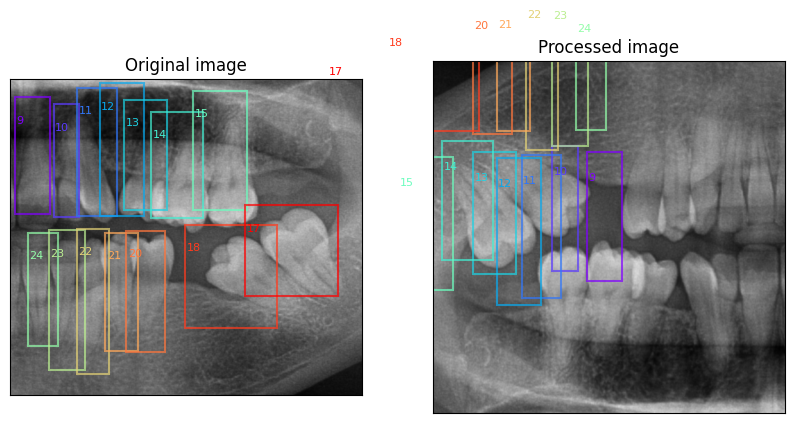

In [14]:
# Process the image and take a look at the processed image and annotations
print(transformed_im.shape)
output = processor(images=transformed_im, annotations=annotations, return_tensors='pt')

# Get the image
output_array = output['pixel_values'].numpy()
output_im = np.transpose(np.squeeze(output_array), (1, 2,0))\

# The labels and bounding boxes
output_labels = list(output['labels'][0]['class_labels'].numpy())

# The bounding boxes
output_bboxes = list(output['labels'][0]['boxes'].numpy())
# The bounding boxes are in YOLO format. We need to convert them into COCO
# For this we need the reference size
reference_size = list(output['labels'][0]['size'].numpy())
h = int(reference_size[0])
w = int(reference_size[1])
output_bboxes_xyxy = [yolo2xywh(list(box), image_width=w, image_height=h) for box in output_bboxes] 

# Some simple image stats
for i, img in enumerate([transformed_im, output_im]):
    print()
    print(f'Image:  {i+1}') 
    print(f'Mean:   {np.mean(img)}')
    print(f'Median: {np.median(img)}')
    print(f'Std:    {np.std(img)}')
    print(f'Min:    {np.min(img)}')
    print(f'Max:    {np.max(img)}')

# Let's plot the image with the bounding boxes after processing
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0] = plot_boxes(image=im, box_list=bbox_list, ax=ax[0], label_list=label_list)
ax[0].set(title='Original image')
ax[1] = plot_boxes(image=output_im, box_list=output_bboxes_xyxy, ax=ax[1], label_list=output_labels)
ax[1].set(title='Processed image')
plt.show()

In [26]:
print(transformed_im.shape)
box = list(bbox_list[0])
print(box)
yolo_box = xywh2yolo(coco_bbox=box, image_width=transformed_im.shape[1], image_height=transformed_im.shape[0])
print(yolo_box)

(708, 789, 3)
[10, 41, 79, 261]
[0.5126742712294043, 0.557909604519774, 0.10012674271229405, 0.3686440677966102]


In [10]:
output_bboxes

[array([0.9359949 , 0.75706214, 0.10012674, 0.3672316 ], dtype=float32),
 array([0.8396705 , 0.74011296, 0.07224331, 0.35593218], dtype=float32),
 array([0.752218  , 0.7676554 , 0.11280107, 0.40536729], dtype=float32),
 array([0.6818758 , 0.7747175 , 0.12674269, 0.4194916 ], dtype=float32),
 array([0.6147021 , 0.7584745 , 0.12167297, 0.34745765], dtype=float32),
 array([0.52598226, 0.72669494, 0.14448667, 0.33757067], dtype=float32),
 array([0.40367556, 0.77330506, 0.1533587 , 0.37711865], dtype=float32),
 array([0.9062103 , 0.33403954, 0.08618498, 0.3601695 ], dtype=float32),
 array([0.8371356 , 0.2987288 , 0.10266165, 0.44209042], dtype=float32),
 array([0.76362485, 0.29519773, 0.08998737, 0.45762712], dtype=float32),
 array([0.6818758 , 0.32485875, 0.09378962, 0.3757062 ], dtype=float32),
 array([0.6134347 , 0.3262712 , 0.10899873, 0.38135594], dtype=float32),
 array([0.3726236 , 0.3757062 , 0.25855514, 0.32485873], dtype=float32),
 array([0.20025349, 0.45550847, 0.26362485, 0.28672